# The goal of this notebook is show how to compute and analyze the technical lag of outdated DIRECT dependencies in npm packages

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load DATA

### npm dependencies

In [2]:
npm_deps = pd.read_csv('./data/npm_dependencies.csv')

In [3]:
npm_deps.sample()

package version        date dependency used_version
6208225  grunt-docma   0.6.9  2017-02-14      docma        1.4.0

### the history of all package versions

In [3]:
npm_versions = pd.read_csv('./data/npm_versions.csv')

In [5]:
npm_versions.sample()

package version        date
3633080  thorin-plugin-mail   1.0.9  2016-08-08

Let's make date into to the correct format

In [8]:
npm_deps['date'] = pd.to_datetime(npm_deps['date'])
npm_versions['date'] = pd.to_datetime(npm_versions['date'])

###### Let's check first how many unique packages make use of dependencies

In [6]:
npm_deps.package.unique().size

429055

##### how many unique packages are used as dependencies

In [7]:
npm_deps.dependency.unique().size

143117

###### let's compute how many dependencies each package version has

In [8]:
numDeps = npm_deps.groupby(['package','version']).count()[['dependency']]

###### distibution of the number of dependencies

In [43]:
numDeps.describe()

dependency
count  3.307216e+06
mean   6.552553e+00
std    9.428491e+00
min    0.000000e+00
25%    2.000000e+00
50%    4.000000e+00
75%    7.000000e+00
max    9.960000e+02

###### Visualization 
We will make us of boxplots to show the distribution. Violin or boxen plots can be use as well (e.g. sns.boxenplot())

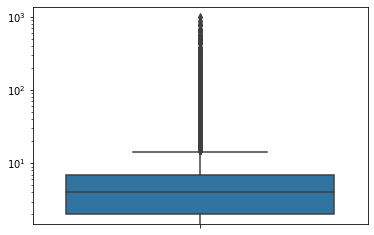

In [50]:
ax = sns.boxplot(y=['dependency'], data=numDeps)
ax.set_yscale('log')

#### Now let's compute the technical lag

To compute the technical lag, we will rely on these two gold standars:

**IDEAL** = Latest available releease

**LAG**= Difference in ***time*** and ****number of versions**** between two given versions.

Note that the **latest available release** is different from the **highest available release**.

The **latest available release** is related to *time*, while the
**highest available release** is related to the version number

First, let's sort the list of packages versions by time (ascending) and give to each package version an incremented number

In [4]:
npm_versions.sort_values(['date','version'], inplace=True)

We sorted the package release from the oldest to the latest, now will give to each package version a number.

In [5]:
npm_versions['order'] = npm_versions.groupby(['package']).cumcount()

In [7]:
print('Number of dependencies:', len(npm_deps))

Number of dependencies: 21674488


let's include the date and the order of each dependency version to the **npm_deps** dataframe

In [6]:
npm_deps = (npm_deps
           .merge(npm_versions.rename(columns={'date':'dep_date',
                                              'package':'dependency',
                                              'version':'used_version'}),
                 on =['dependency','used_version'])
            .dropna()
           )
print('Number of dependencies:', len(npm_deps))

Number of dependencies: 21323888


If you noticed there are about 1.6% of dependencies ignored. These dependencies couldn't be found in the history of package versions.

Let's check our dataframe now

In [9]:
npm_deps.sample()

package version       date      dependency used_version  \
4964134  expect-to-core   0.8.0 2016-03-28  compare-errors        0.3.0   

          dep_date  order  
4964134 2015-11-05      2

Now, we have all information about the **used version**.

Let's get the information about the **latest available version** at the release date of the package releases

In [9]:
npm_deps = pd.merge_asof(
            (npm_deps
             .sort_values('date')),
            (npm_versions
             .rename(columns={'package':'dependency',
                              'version':'latest_version',
                              'date':'latest_date',
                              'order':'latest_order'
                             })
             .sort_values(['latest_date','latest_version'])
            ),
            left_on='date',
            right_on='latest_date',
            left_by='dependency',
            right_by='dependency',
        )
print('Number of dependencies:', len(npm_deps))

Number of dependencies: 21323888


Now, it is easy to compute the technical lag, but first let's check how many outdated packages each package version has

In [10]:
npm_deps['outdated'] = (npm_deps.latest_order == npm_deps.order)

In [ ]:
numDeps = npm_deps.groupby(['package','version','outdated']).count()[['dependency']].reset_index()

In [24]:
numDeps.groupby('outdated').describe()

dependency                                               
              count      mean       std  min  25%  50%  75%    max
outdated                                                          
False     1481128.0  3.300803  4.715964  1.0  1.0  2.0  3.0  358.0
True      3102482.0  5.297364  7.192182  1.0  2.0  3.0  6.0  657.0

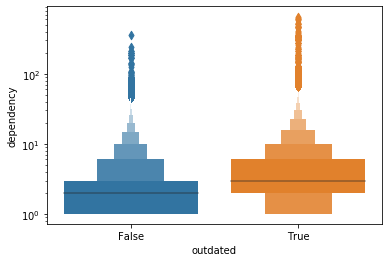

In [21]:
ax = sns.boxenplot(y='dependency', x='outdated', data=numDeps)
ax.set_yscale('log')

##### So, it seems that 69.4% of the dependencies are up-to-date. 

### Let's compute technical lag using ***versions***.
We will compute the technical lag in terms of *versions* at the release date of each package version.


In [11]:
npm_deps['versionLag'] = npm_deps.latest_order - npm_deps.order

Let's check the distribution of the version lag at the level of package version

In [12]:
# For all dependendencies
npm_deps.versionLag.describe()

count    2.132389e+07
mean     1.659756e+00
std      7.201368e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.750000e+02
Name: versionLag, dtype: float64

In [13]:
# For outdated dependendencies ONLY
npm_deps.query('versionLag != 0').versionLag.describe()

count    4.888912e+06
mean     7.239331e+00
std      1.363097e+01
min      1.000000e+00
25%      1.000000e+00
50%      3.000000e+00
75%      8.000000e+00
max      9.750000e+02
Name: versionLag, dtype: float64

### We can aggregate the technical lag at the level of a package release

In [27]:
numDeps = npm_deps.groupby(['package','version','date'])['versionLag'].sum().reset_index()

In [28]:
# For all dependendencies 
numDeps.versionLag.describe()

count    3.288633e+06
mean     1.076206e+01
std      3.727685e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      5.000000e+00
max      6.031000e+03
Name: versionLag, dtype: float64

In [29]:
# For outdated dependendencies ONLY
numDeps.query('versionLag != 0').versionLag.describe()

count    1.481128e+06
mean     2.389561e+01
std      5.264498e+01
min      1.000000e+00
25%      2.000000e+00
50%      7.000000e+00
75%      2.100000e+01
max      6.031000e+03
Name: versionLag, dtype: float64

### Now, let's see the evolution of this aggregation over time.

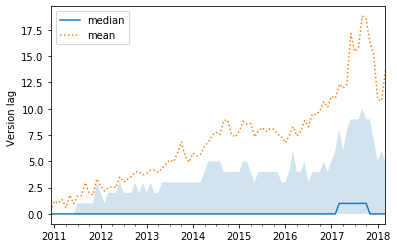

In [34]:
# For all dependendencies 
fig.set_size_inches(18,3)
size=[12,20,70]
df_=(numDeps
     .groupby(pd.Grouper(key='date', freq='1M'))['versionLag']
     .describe()[['mean', '25%', '50%', '75%']] 
    )

df_['50%'].rename('median').plot()
ax=df_['mean'].plot(style=':')
ax.fill_between(df_.index, df_['25%'], df_['75%'], alpha=0.2)

ax.set(
    xlabel='',
    ylabel='Version lag '
)
ax.legend(loc='upper left')


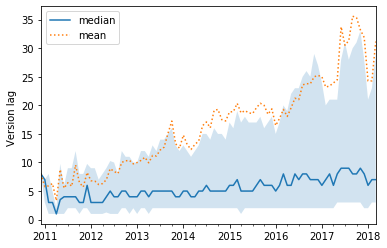

In [35]:
# For outdated dependendencies ONLY
fig.set_size_inches(18,3)
size=[12,20,70]
df_=(numDeps.query('versionLag != 0')
     .groupby(pd.Grouper(key='date', freq='1M'))['versionLag']
     .describe()[['mean', '25%', '50%', '75%']] 
    )

df_['50%'].rename('median').plot()
ax=df_['mean'].plot(style=':')
ax.fill_between(df_.index, df_['25%'], df_['75%'], alpha=0.2)

ax.set(
    xlabel='',
    ylabel='Version lag '
)
ax.legend(loc='upper left')


### It seems that the version lag is increasing over time. In the sense that new versions come with more outdated packages.